In [1]:
!pip install ultralytics opencv-python-headless matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 22.4 MB/s eta 0:00:00


In [3]:
import os
from google.colab import userdata

# 1. Get credentials from Colab Secrets
# Note: You must add KAGGLE_USERNAME and KAGGLE_KEY in the sidebar (Key icon) first.
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')

# 2. Download the dataset (Authentication is now automatic)
!kaggle datasets download -d norbertelter/pcb-defect-dataset

# 3. Unzip
import zipfile
with zipfile.ZipFile("pcb-defect-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/pcb_dataset")

print("✅ Dataset Downloaded & Extracted using Secrets!")

Dataset URL: https://www.kaggle.com/datasets/norbertelter/pcb-defect-dataset
License(s): unknown
 89% 0.98G/1.10G [00:11<00:02, 52.3MB/s]
100% 1.10G/1.10G [00:11<00:00, 98.9MB/s]
✅ Dataset Downloaded & Extracted using Secrets!


In [4]:
import os
import shutil
import glob
import random
import yaml

# 1. Setup a clean destination structure
dest_dir = '/content/final_dataset'
for split in ['train', 'val']:
    os.makedirs(f"{dest_dir}/images/{split}", exist_ok=True)
    os.makedirs(f"{dest_dir}/labels/{split}", exist_ok=True)

print("🧹 Scanning for all images and labels...")

# 2. Find ALL jpg/txt files in the messy folder (Recursive search)
source_dir = '/content/pcb_dataset'
all_images = glob.glob(f"{source_dir}/**/*.jpg", recursive=True)
print(f"   -> Found {len(all_images)} total images.")

if len(all_images) == 0:
    raise FileNotFoundError("❌ No images found! Did the dataset download correctly?")

# 3. Move files to the new clean folder
moved_count = 0
for img_path in all_images:
    # Find corresponding label file
    # (Assumes label has same name as image but ends in .txt)
    base_name = os.path.splitext(os.path.basename(img_path))[0]
    parent_dir = os.path.dirname(img_path)

    # Search for label in the same folder or a parallel 'labels' folder
    possible_label_paths = [
        os.path.join(parent_dir, f"{base_name}.txt"), # Same folder
        os.path.join(parent_dir.replace("images", "labels"), f"{base_name}.txt"), # Parallel folder
        os.path.join(parent_dir.replace("images", "labels").replace("test", "train"), f"{base_name}.txt") # Cross folder
    ]

    label_path = None
    for p in possible_label_paths:
        if os.path.exists(p):
            label_path = p
            break

    if label_path:
        # Decide split (80% train, 20% val)
        split = 'train' if random.random() < 0.8 else 'val'

        # Copy Image
        shutil.copy(img_path, f"{dest_dir}/images/{split}/{base_name}.jpg")
        # Copy Label
        shutil.copy(label_path, f"{dest_dir}/labels/{split}/{base_name}.txt")

        moved_count += 1

print(f"✅ Successfully reorganized {moved_count} image/label pairs into '{dest_dir}'.")

# 4. Create a fresh data.yaml pointing to the NEW folder
yaml_content = f"""
path: {dest_dir}
train: images/train
val: images/val

# Classes (Standard DeepPCB classes)
nc: 6
names: ['missing_hole', 'mouse_bite', 'open_circuit', 'short', 'spur', 'spurious_copper']
"""

yaml_path = f"{dest_dir}/data.yaml"
with open(yaml_path, 'w') as f:
    f.write(yaml_content)

print(f"✅ Created fresh config at: {yaml_path}")

🧹 Scanning for all images and labels...
   -> Found 10668 total images.
✅ Successfully reorganized 8001 image/label pairs into '/content/final_dataset'.
✅ Created fresh config at: /content/final_dataset/data.yaml


In [5]:
from ultralytics import YOLO

# Load model
model = YOLO('yolov8n.pt')

# Train using the CLEAN data.yaml
print("🚀 Starting Training on Clean Dataset...")
results = model.train(
    data='/content/final_dataset/data.yaml',
    epochs=15,
    imgsz=640
)

print("✅ Training Complete!")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
🚀 Starting Training on Clean Dataset...
Ultralytics 8.3.249 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/final_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=15, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=

In [6]:
import cv2
import glob
import random
import os
from ultralytics import YOLO
import matplotlib.pyplot as plt

# 1. SETUP
# ---------------------------------------------------------
# Load your just-trained model
model_path = '/content/runs/detect/train/weights/best.pt'
model = YOLO(model_path)

# Create a folder to save your results for GitHub
output_dir = '/content/submission_evidence'
os.makedirs(output_dir, exist_ok=True)

# Get test images (we use the validation set we created earlier)
test_images = glob.glob('/content/final_dataset/images/val/*.jpg')
# Pick 5 random images to demonstrate
selected_images = random.sample(test_images, 5)

print(f"🚀 Running Analysis on {len(selected_images)} images...\n")

# 2. THE LOGIC LOOP (Requirement 3.1 - 3.4)
# ---------------------------------------------------------
for i, img_path in enumerate(selected_images):
    # Analyze
    results = model(img_path, verbose=False)

    # Load image for drawing
    img = cv2.imread(img_path)
    img_viz = img.copy()
    h, w, _ = img.shape

    print(f"📄 REPORT FOR IMAGE: {os.path.basename(img_path)}")
    print(f"{'DEFECT':<20} | {'CONF':<8} | {'CENTER (x,y)':<15} | {'SEVERITY'}")
    print("-" * 65)

    defect_count = 0

    for r in results:
        for box in r.boxes:
            defect_count += 1

            # --- Logic 1: Coordinates ---
            x1, y1, x2, y2 = box.xyxy[0].tolist()
            conf = box.conf[0].item()
            cls = int(box.cls[0].item())
            label = model.names[cls]

            # --- Logic 2: Center Calculation ---
            cx, cy = int((x1 + x2) / 2), int((y1 + y2) / 2)

            # --- Logic 3: Severity (Based on Defect Area vs Image Area) ---
            defect_area = (x2 - x1) * (y2 - y1)
            img_area = w * h
            ratio = (defect_area / img_area) * 100

            if ratio > 5.0:
                severity = "CRITICAL 🔴"
                color = (0, 0, 255) # Red (BGR)
            elif ratio > 1.0:
                severity = "MODERATE 🟠"
                color = (0, 165, 255) # Orange
            else:
                severity = "MINOR 🟢"
                color = (0, 255, 0) # Green

            # Print to console (The Report)
            print(f"{label:<20} | {conf:.2f}     | ({cx}, {cy})      | {severity}")

            # Draw on Image (The Visuals)
            # Box
            cv2.rectangle(img_viz, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)
            # Label background
            cv2.rectangle(img_viz, (int(x1), int(y1)-20), (int(x2), int(y1)), color, -1)
            # Label Text
            cv2.putText(img_viz, f"{label} {conf:.2f}", (int(x1), int(y1)-5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)
            # Center Dot
            cv2.circle(img_viz, (cx, cy), 3, (255, 0, 0), -1)

    if defect_count == 0:
        print("✅ No defects detected.")
        # Add a text saying "PASSED"
        cv2.putText(img_viz, "QC PASSED", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 3)

    print("\n")

    # Save the file
    save_path = f"{output_dir}/result_{i}.jpg"
    cv2.imwrite(save_path, img_viz)

print(f"✅ Processing Done! Check the folder '{output_dir}'")

🚀 Running Analysis on 5 images...

📄 REPORT FOR IMAGE: rotation_90_light_01_missing_hole_04_2_600.jpg
DEFECT               | CONF     | CENTER (x,y)    | SEVERITY
-----------------------------------------------------------------
open_circuit         | 0.73     | (96, 372)      | MINOR 🟢
open_circuit         | 0.61     | (254, 442)      | MINOR 🟢


📄 REPORT FOR IMAGE: rotation_270_light_11_spurious_copper_06_1_600.jpg
DEFECT               | CONF     | CENTER (x,y)    | SEVERITY
-----------------------------------------------------------------
spurious_copper      | 0.83     | (431, 500)      | MINOR 🟢
spurious_copper      | 0.76     | (62, 359)      | MINOR 🟢
spurious_copper      | 0.68     | (418, 592)      | MINOR 🟢


📄 REPORT FOR IMAGE: rotation_270_light_06_short_03_3_600.jpg
DEFECT               | CONF     | CENTER (x,y)    | SEVERITY
-----------------------------------------------------------------
short                | 0.71     | (71, 208)      | MINOR 🟢


📄 REPORT FOR IMAGE: ro

Ultralytics 8.3.249 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3027.2±781.8 MB/s, size: 124.6 KB)
val: Scanning /content/final_dataset/labels/val.cache... 1514 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1514/1514 2.5Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 95/95 5.4it/s 17.6s
                   all       1514       3114      0.971      0.976      0.983      0.556
          missing_hole        254        509      0.968       0.98      0.989      0.573
            mouse_bite        267        560      0.968      0.968      0.988      0.546
          open_circuit        258        510      0.978      0.998      0.992      0.609
                 short        234        477      0.962      0.962      0.961      0.549
                  spur        252        

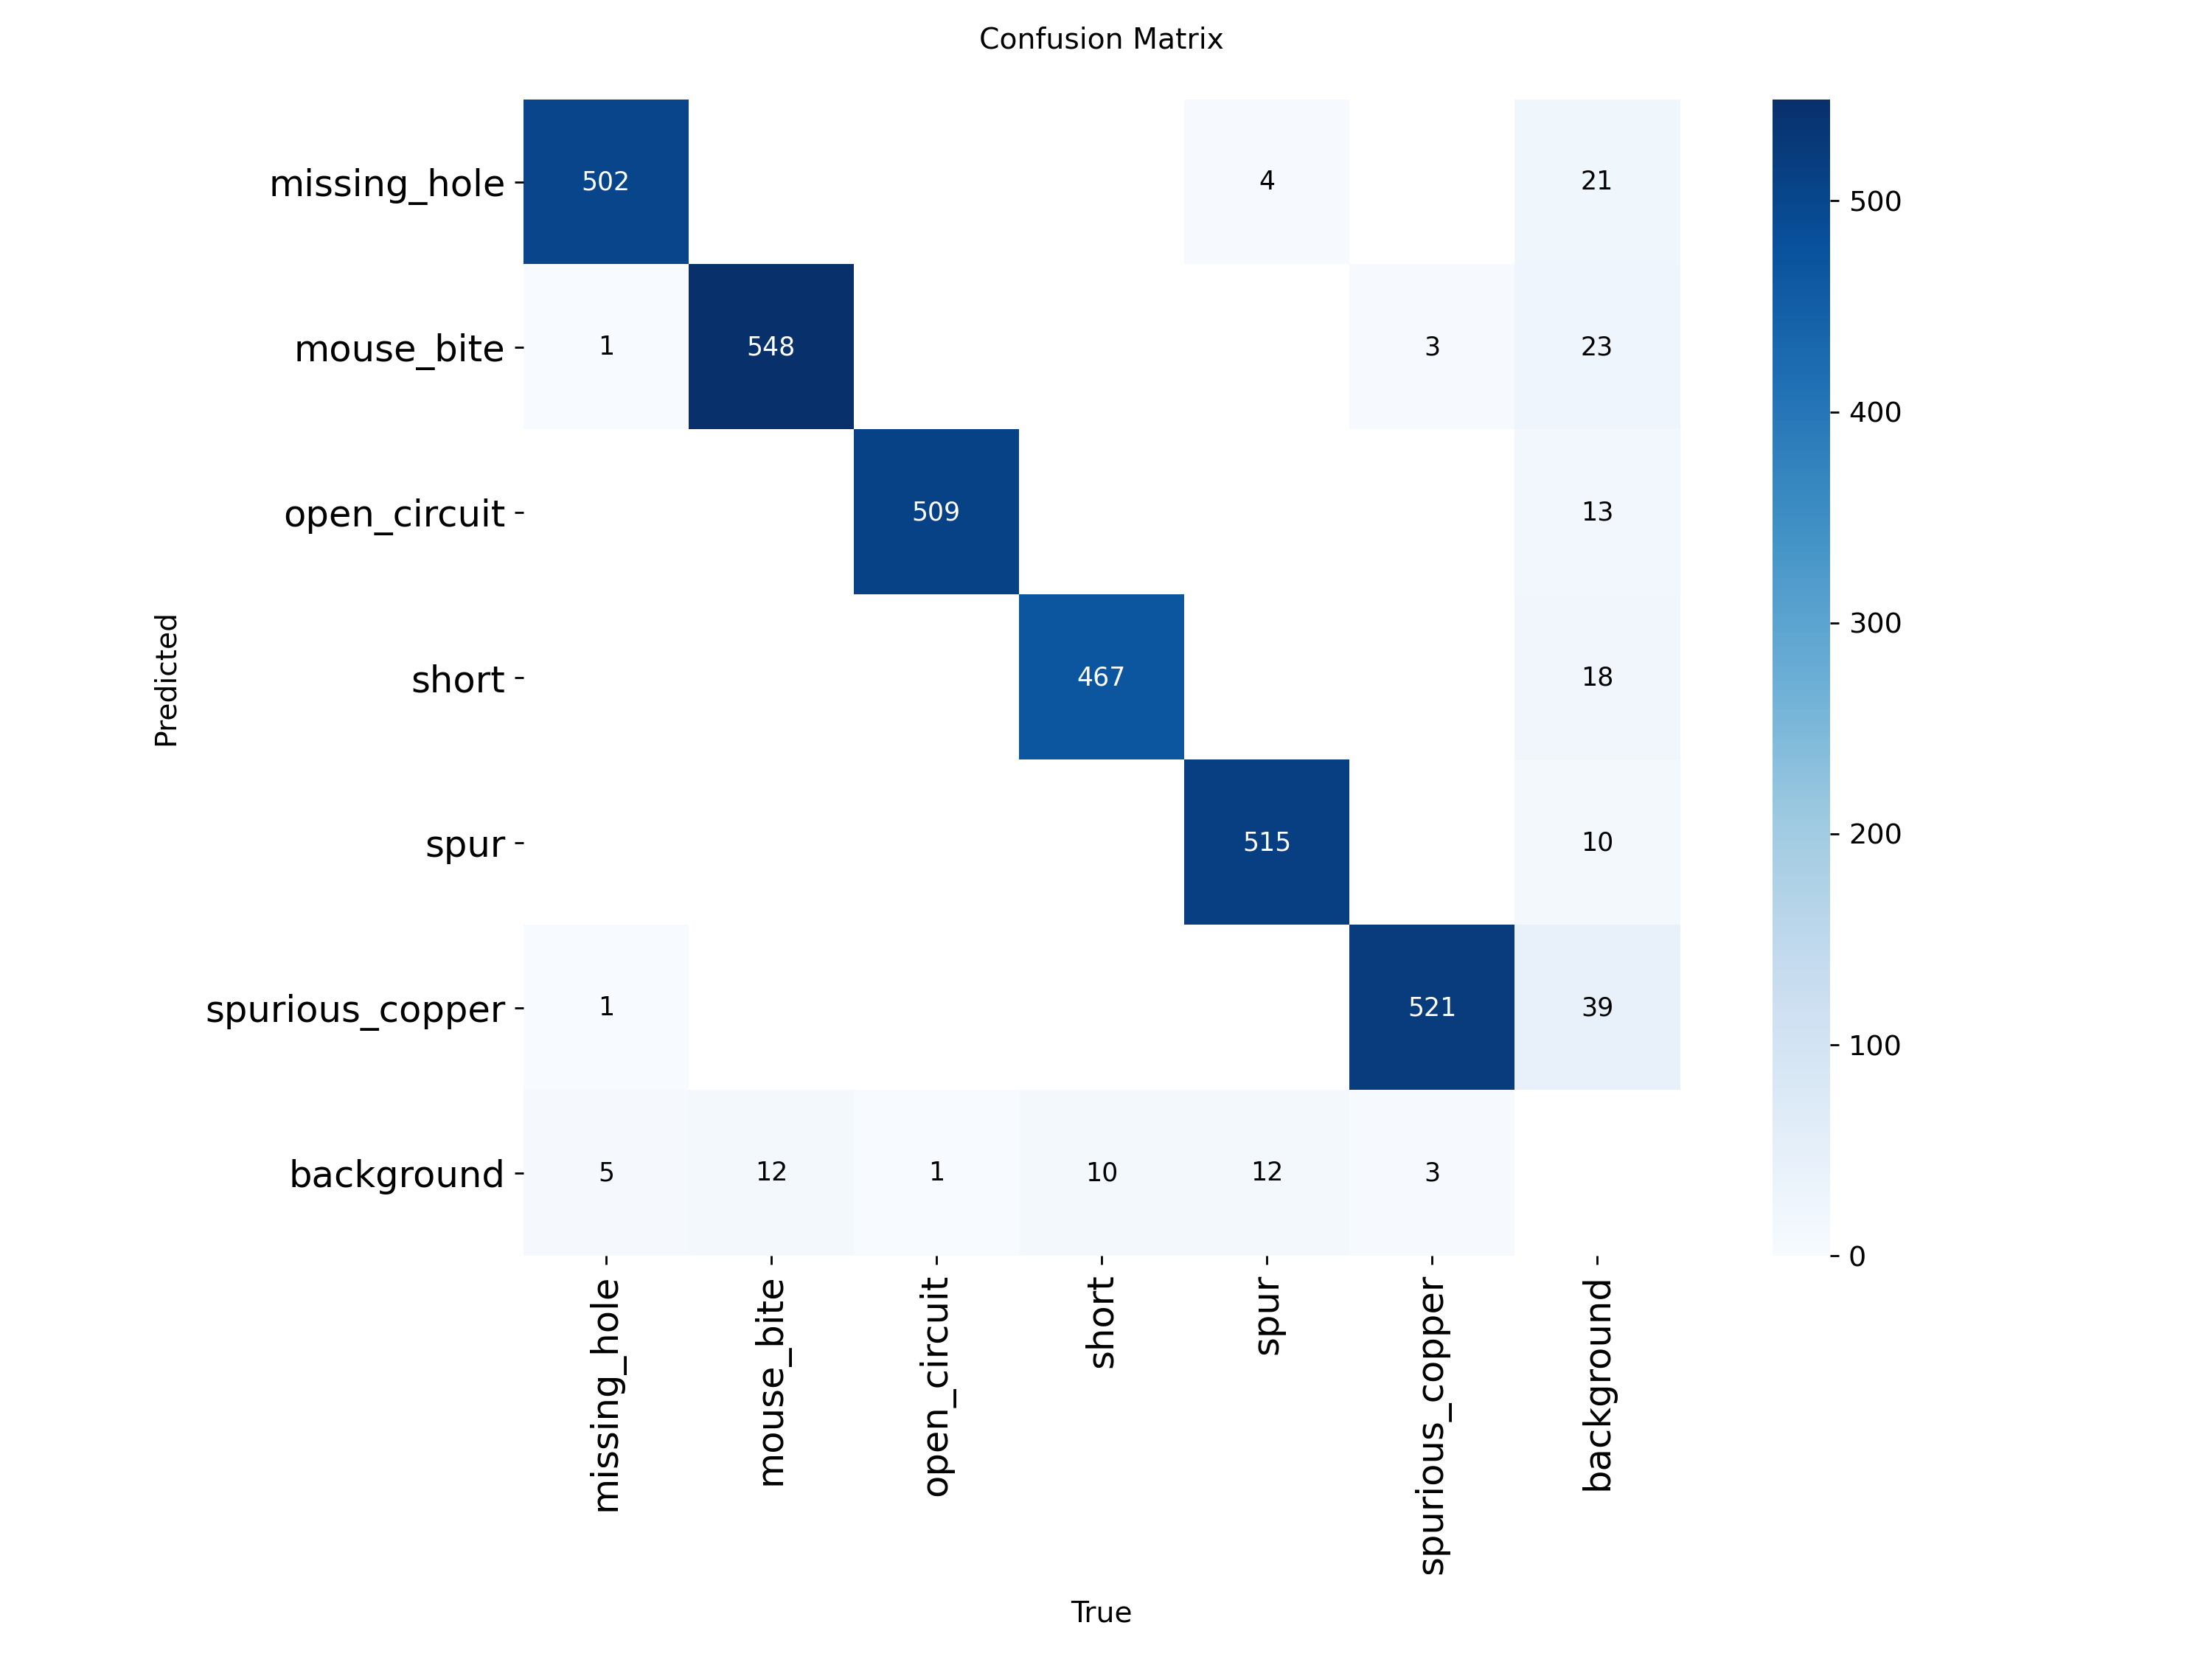

In [7]:
from ultralytics import YOLO
import matplotlib.pyplot as plt

model = YOLO('/content/runs/detect/train/weights/best.pt')

# Run validation on the test set
metrics = model.val(data='/content/final_dataset/data.yaml')

# The confusion matrix is automatically saved in runs/detect/train(or val)
# Let's display it
import IPython.display
IPython.display.Image(filename=f'{metrics.save_dir}/confusion_matrix.png', width=600)

In [8]:
!zip -r submission_evidence.zip /content/submission_evidence

  adding: content/submission_evidence/ (stored 0%)
  adding: content/submission_evidence/result_4.jpg (deflated 0%)
  adding: content/submission_evidence/result_3.jpg (deflated 1%)
  adding: content/submission_evidence/result_0.jpg (deflated 0%)
  adding: content/submission_evidence/result_1.jpg (deflated 0%)
  adding: content/submission_evidence/result_2.jpg (deflated 0%)
